# Exploratory Data Analysis

### Description

* Arabizi is a combination of english and arabic languages making arabic "izi" for communicatiopn over internet.

In [1]:
import sys 
sys.path.append('../scripts')

In [2]:
import os
import re
import pandas as pd
import numpy as np
from collections import Counter

from config import Config
from tqdm.auto import tqdm
import seaborn as sb
import matplotlib.pyplot as plt
from utils import remove_repetitions, replace_accents, delete_outliers, show_lengths_distribution, make_folds

### Some statistics

In [3]:
train_df = pd.read_csv(os.path.join(Config.data_dir, 'Train.csv'))
test_df = pd.read_csv(os.path.join(Config.data_dir, 'Test.csv'))

In [4]:
total_samples = len(train_df) + len(test_df)
total_samples

100000

In [5]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
label,70000.0,0.127771,0.973889,-1.0,-1.0,1.0,1.0,1.0


In [6]:
train_df.isna().sum()

ID       0
text     0
label    0
dtype: int64

In [7]:
test_df.isna().sum()

ID      0
text    0
dtype: int64

In [8]:
train_df.text.duplicated().sum()

0

In [9]:
test_df.text.duplicated().sum()

0

In [10]:
train_df.tail()

,ID,text,label
69995,ZRSR7TZ,pff bayna beli kbira f wejhakk yakhiii rouhi r...,-1
69996,QNQVEIH,aman lmara jeya zidou t3am9ou fel a7deeth akth...,-1
69997,LJ2K9MD,winha nakhtabha hhhhh,-1
69998,5RZ1T7I,fachel enta w houwa,-1
69999,WZCF7CL,nchla lyouma nesm3ou a5beer bahiya 3la jem3iya,1


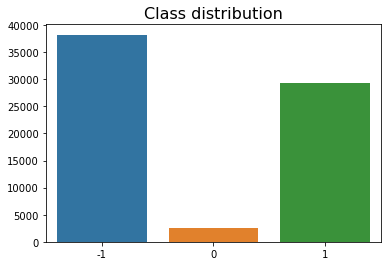

In [11]:
sb.barplot(x=train_df.label.unique(), y=train_df.label.value_counts().tolist(), data=train_df)
plt.title('Class distribution', size=16)
plt.show()

In [12]:
train_df[train_df['label'] == 0].shape, train_df[train_df['label'] == -1].shape, train_df[train_df['label'] == 1].shape

((2466, 3), (29295, 3), (38239, 3))

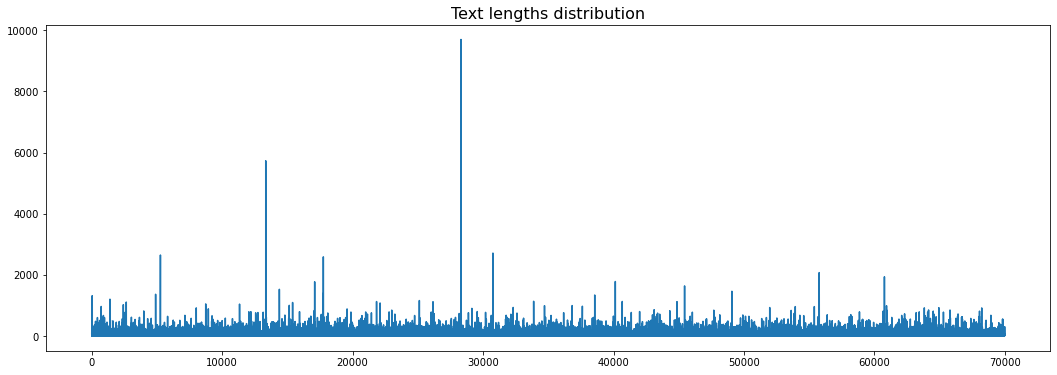

In [13]:
show_lengths_distribution(data = train_df)

In [14]:
idx = np.random.randint(low=0, high=len(train_df))
len(train_df.iloc[idx].text)

140

# Data Preprocessing

The given dataset has :
1) many texts with letters that are repeated exaggeratedly. --> limit these repetitions
2) many texts with patterns that are repeated exaggeratedly like "hahahaha". --> limit these repetitions
3) many french words that are known to have accented letters --> replace these letters

### Data cleaning

In [15]:
# example of repeated letters removal
str1 = train_df.iloc[0].text + " 100000 pfffff aaaaaahhh"
str2 = "kolha z3am kan fl klam wlfe3l yjibou rabby ye5i tawwa fe9tou elli tounes \
f 7aaaaaaala w fa9r w w etc sa777a noum w yezziwna ml klam inty comme un homme d affaire \
ch 9addemt lebladek 9addah mn mawton cho8l fl blayes lmzamra t5addem 9adddah t5allles fl \
3am 3la tharewtk enk tkoun korza moush 3ib mais l3ib lmotajra b nes elli ma tekseb welou"
str3 = "aymen khamassi mehdi el gaied jed ben aoun mohamed tarres ti bara nayek aala el \
bhema hahahahahahahahahahahahahahahahhahahahahahahahahahahahahahhahahahahahahahahahahahahahahhahahhahahahahhahahahhahahahhahahahhahahahhahahahahhahahahhahaha"
str4 = "mala karyoyka ach nfid mino lazmo lahrisa fi tiiittttttt"
str5 = 'walah ir bkit hata win nachfou dmou3i rabi ychfikom ya rab ana gariba wda3wat algarib moustajaba yaaaaaaaarab achfihom fi 2'


In [16]:
remove_repetitions(sequence=replace_accents(text=str3), n_letters_repetitions=2, n_pattern_repetitions=2)

'aymen khamassi mehdi el gaied jed ben aoun mohamed tarres ti bara nayek l el bhema '

In [17]:
%%time
train_df['text'] = train_df['text'].apply(
    lambda txt: remove_repetitions(sequence=replace_accents(text=txt), n_letters_repetitions=2, n_pattern_repetitions=2)
)
train_df.head()

CPU times: user 2.58 s, sys: 6.06 ms, total: 2.59 s
Wall time: 2.61 s


,ID,text,label
0,13P0QT0,3sbaa lek ou le seim riahi ou 3sbaa le ca,-1
1,SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1
2,V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1
3,U0TTYY8,ak slouma,1
4,68DX797,entom titmanou lina a7na 3iid moubarik a7na ch...,-1


In [18]:
# SAVE CLEANED_DATA
train_df.to_csv(
    os.path.join(Config.data_dir, 'cleaned_train.csv'), 
    index=False
)

## Create dataset for k-folds cross-validation

In [19]:
dataset, n_folds = make_folds(data=train_df, n_folds=5, preprocess=False, stratified=True)
dataset.tail()

Splitting:   0%|          | 0/5 [00:00<?, ?it/s]

,ID,text,label,fold
69995,ZRSR7TZ,pff bayna beli kbira f wejhakk yakhii rouhi ro...,-1,2
69996,QNQVEIH,aman lmara jeya zidou t3am9ou fel a7deeth akth...,-1,1
69997,LJ2K9MD,winha nkhtbh hh,-1,4
69998,5RZ1T7I,fachel enta w houwa,-1,4
69999,WZCF7CL,nchla lyouma nesm3ou a5beer bahiya 3la jem3iya,1,4


In [20]:
dataset.to_csv(
    os.path.join(Config.data_dir, f'Train_{n_folds}_folds.csv'), 
    index=False
)

# Visualize splits proportions

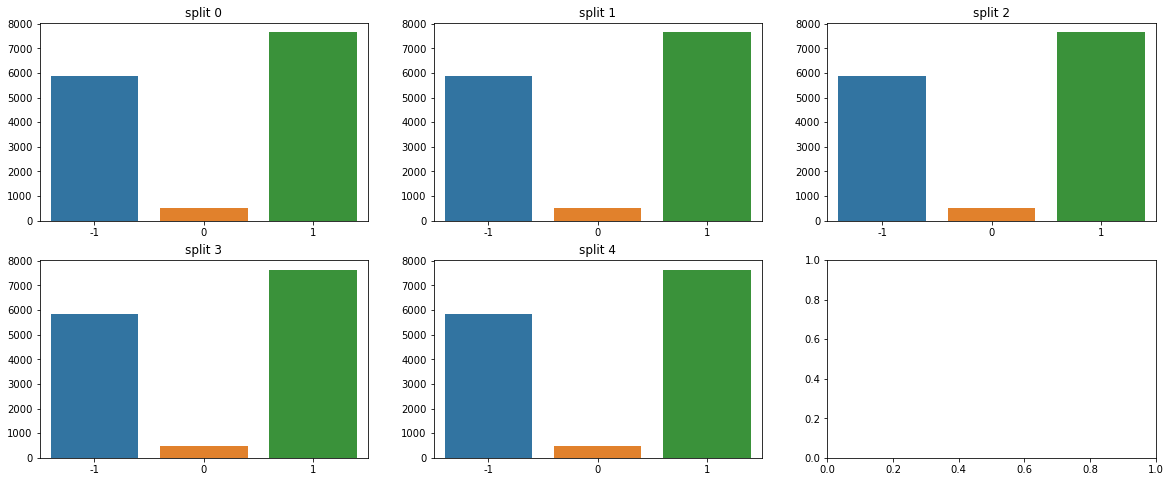

In [65]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 8))

split=0
for r in range(2):
    for c in range(3):
        try:
            counts = dataset[dataset['fold'] == split].label.value_counts()
            sb.barplot(x=counts.index, y=counts.values, ax=axes[r, c])
            axes[r, c].set_title(f'split {split}')
            split+=1
        except:
            pass
        